In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
from qiskit.quantum_info.analysis import average_data
from qiskit.quantum_info import state_fidelity
from sklearn.metrics import accuracy_score,log_loss
import numpy as np

np.random.seed(0)

In [2]:
y = np.array(([1,0]))
y1 = np.array(([0,1]))
State_labels = [y,y1]

In [3]:
def circuit(params,X,y):
    
    n_qubits = len(params)
    layers = len(params[0][0])
    qc = QuantumCircuit(n_qubits)
    
    
    for i in range(len(params)):
        
        for id,j in enumerate(params[i]):
            qc.u3(X[0],X[1],0,i)
            
            qc.u3(j[0],j[1],j[2],i)
            if n_qubits > 1 and (id < layers-1):
                qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    counts = result_sim.get_statevector(qc)
    vals = state_fidelity(counts,State_labels[0])
    vals1 = state_fidelity(counts,State_labels[1])
    #print(average_data(counts,vals))
    return [vals,vals1]

In [4]:
def cost(params,X,y):
    
    value = []
    
    for i in range(len(X)):
        value.append(circuit(params,X[i],y[i]))
    res = log_loss(y,value,labels=y_train)
   # print(res)
    return res
        

In [5]:
def gradient(params,x,y):
    
    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                
        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,x,y)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
                
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
    
                F2 = cost(params,x,y)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g
    
def optimize(params,X,y,lr): 
    g = gradient(params,X,y)
    
    new_weights = params - (lr*g)
    
    return new_weights

In [6]:
def _circle(samples):
    centers = np.array([[0, 0]])
    radii = np.array([np.sqrt(1.8/np.pi)])
    data=[]
    dim = 2
    labels=[]
    np.random.seed(1000)
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for c, r in zip(centers, radii):  
            if np.linalg.norm(x - c) < r:
                y = 1 

        data.append(x)
        labels.append(y)
            
    return np.array(data), np.array(labels)

(810, 2) (90, 2)


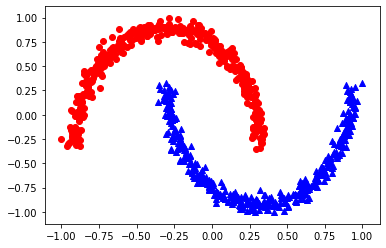

In [7]:
from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt
#X,l = _circle(1000)
X,l = make_moons(n_samples=900,random_state=0,noise=0.04)
x_train,x_test,y_train,y_test = train_test_split(X,l,test_size=0.1,random_state=0,stratify=l)
print(x_train.shape,x_test.shape)
scale = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scale.transform(x_train)
x_test = scale.transform(x_test)

plt.scatter(x_train[:,0][y_train==0], x_train[:,1][y_train==0], marker='o', color='red', label='train 0')
plt.scatter(x_train[:,0][y_train==1], x_train[:,1][y_train==1], marker='^', color='blue', label='train 1')

In [8]:
def predict(params,X):
    
    n_qubits = len(params)
    layers = len(params[0][0])
    qc = QuantumCircuit(n_qubits)
    
    
    for i in range(len(params)):
        
        for id,j in enumerate(params[i]):
            qc.u3(X[0],X[1],0,i)
            
            qc.u3(j[0],j[1],j[2],i)
            if n_qubits > 1 and (id < layers-1):
                qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    counts = result_sim.get_statevector(qc)
    
        
    vals = state_fidelity(counts,State_labels[0])
    
    vals1 = state_fidelity(counts,State_labels[1])
    #print(average_data(counts,vals))
    if vals > vals1:
        return abs(1-vals)
    else:
        
        return vals1
    

In [9]:
from tqdm import tqdm
np.random.seed(100)
params = np.random.rand(1,6,3)
weights = params
score = np.inf
lr = 0.2
test_loss = []
for i in tqdm(range(1000)):

    index = np.random.randint(0,len(x_train),20)
    x_batch,y_batch = x_train[index],y_train[index]
    #if i+1 == 500 or i+1 == 800:
     #   lr = lr - 0.05
    weights = optimize(weights,x_batch,y_batch,lr=lr)
    
    res = cost(weights,x_test,y_test)
    test_loss.append(res)
    #acc_test = accuracy_score(y_test,np.round(np.array(res)))
        
    if res < score:
        score = res
        var = weights
    print(
        "Epoch: {:2d} | testing accuracy: {:4f}".format(i+1,res))

  0%|          | 1/1000 [00:10<3:00:27, 10.84s/it]

Epoch:  1 | testing accuracy: 0.702237


  0%|          | 2/1000 [00:21<3:00:46, 10.87s/it]

Epoch:  2 | testing accuracy: 0.600879


  0%|          | 3/1000 [00:32<3:00:53, 10.89s/it]

Epoch:  3 | testing accuracy: 0.590562


  0%|          | 4/1000 [00:43<3:00:40, 10.88s/it]

Epoch:  4 | testing accuracy: 0.558180


  0%|          | 5/1000 [00:54<3:01:12, 10.93s/it]

Epoch:  5 | testing accuracy: 0.496094


  1%|          | 6/1000 [01:05<3:00:26, 10.89s/it]

Epoch:  6 | testing accuracy: 0.504841


  1%|          | 7/1000 [01:16<3:02:13, 11.01s/it]

Epoch:  7 | testing accuracy: 0.452597


  1%|          | 8/1000 [01:27<3:01:15, 10.96s/it]

Epoch:  8 | testing accuracy: 0.388533


  1%|          | 9/1000 [01:38<3:03:04, 11.08s/it]

Epoch:  9 | testing accuracy: 0.359905


  1%|          | 10/1000 [01:49<3:02:18, 11.05s/it]

Epoch: 10 | testing accuracy: 0.331875


  1%|          | 11/1000 [02:00<3:01:36, 11.02s/it]

Epoch: 11 | testing accuracy: 0.297817


  1%|          | 12/1000 [02:11<3:01:13, 11.01s/it]

Epoch: 12 | testing accuracy: 0.290814


  1%|▏         | 13/1000 [02:23<3:02:21, 11.09s/it]

Epoch: 13 | testing accuracy: 0.274050


  1%|▏         | 14/1000 [02:36<3:12:22, 11.71s/it]

Epoch: 14 | testing accuracy: 0.270941


  2%|▏         | 15/1000 [02:48<3:12:47, 11.74s/it]

Epoch: 15 | testing accuracy: 0.268381


  2%|▏         | 16/1000 [02:59<3:10:09, 11.59s/it]

Epoch: 16 | testing accuracy: 0.263452


  2%|▏         | 17/1000 [03:16<3:35:23, 13.15s/it]

Epoch: 17 | testing accuracy: 0.253752


  2%|▏         | 18/1000 [03:30<3:43:24, 13.65s/it]

Epoch: 18 | testing accuracy: 0.240624


  2%|▏         | 19/1000 [03:46<3:51:43, 14.17s/it]

Epoch: 19 | testing accuracy: 0.238736


  2%|▏         | 20/1000 [04:00<3:49:35, 14.06s/it]

Epoch: 20 | testing accuracy: 0.259952


  2%|▏         | 21/1000 [04:13<3:47:25, 13.94s/it]

Epoch: 21 | testing accuracy: 0.244111


  2%|▏         | 22/1000 [04:27<3:46:02, 13.87s/it]

Epoch: 22 | testing accuracy: 0.236916


  2%|▏         | 23/1000 [04:41<3:45:08, 13.83s/it]

Epoch: 23 | testing accuracy: 0.215186


  2%|▏         | 24/1000 [04:54<3:44:08, 13.78s/it]

Epoch: 24 | testing accuracy: 0.212900


  2%|▎         | 25/1000 [05:08<3:45:21, 13.87s/it]

Epoch: 25 | testing accuracy: 0.214780


  3%|▎         | 26/1000 [05:22<3:43:22, 13.76s/it]

Epoch: 26 | testing accuracy: 0.235255


  3%|▎         | 27/1000 [05:36<3:42:12, 13.70s/it]

Epoch: 27 | testing accuracy: 0.220845


  3%|▎         | 28/1000 [05:49<3:41:35, 13.68s/it]

Epoch: 28 | testing accuracy: 0.204688


  3%|▎         | 29/1000 [06:03<3:41:33, 13.69s/it]

Epoch: 29 | testing accuracy: 0.201362


  3%|▎         | 30/1000 [06:17<3:41:36, 13.71s/it]

Epoch: 30 | testing accuracy: 0.204566


  3%|▎         | 31/1000 [06:30<3:41:37, 13.72s/it]

Epoch: 31 | testing accuracy: 0.200383


  3%|▎         | 32/1000 [06:43<3:36:06, 13.39s/it]

Epoch: 32 | testing accuracy: 0.199801


  3%|▎         | 33/1000 [06:55<3:27:37, 12.88s/it]

Epoch: 33 | testing accuracy: 0.205394


  3%|▎         | 34/1000 [07:08<3:27:55, 12.91s/it]

Epoch: 34 | testing accuracy: 0.197951


  4%|▎         | 35/1000 [07:21<3:31:56, 13.18s/it]

Epoch: 35 | testing accuracy: 0.196062


  4%|▎         | 36/1000 [07:35<3:34:26, 13.35s/it]

Epoch: 36 | testing accuracy: 0.192438


  4%|▎         | 37/1000 [07:49<3:35:29, 13.43s/it]

Epoch: 37 | testing accuracy: 0.200256


  4%|▍         | 38/1000 [08:02<3:35:59, 13.47s/it]

Epoch: 38 | testing accuracy: 0.191185


  4%|▍         | 39/1000 [08:16<3:36:33, 13.52s/it]

Epoch: 39 | testing accuracy: 0.194472


  4%|▍         | 40/1000 [08:30<3:36:24, 13.53s/it]

Epoch: 40 | testing accuracy: 0.187909


  4%|▍         | 41/1000 [08:43<3:36:36, 13.55s/it]

Epoch: 41 | testing accuracy: 0.198587


  4%|▍         | 42/1000 [08:57<3:36:48, 13.58s/it]

Epoch: 42 | testing accuracy: 0.183535


  4%|▍         | 43/1000 [09:10<3:36:41, 13.59s/it]

Epoch: 43 | testing accuracy: 0.194741


  4%|▍         | 44/1000 [09:24<3:36:48, 13.61s/it]

Epoch: 44 | testing accuracy: 0.181897


  4%|▍         | 45/1000 [09:38<3:37:44, 13.68s/it]

Epoch: 45 | testing accuracy: 0.181562


  5%|▍         | 46/1000 [09:52<3:37:16, 13.67s/it]

Epoch: 46 | testing accuracy: 0.186388


  5%|▍         | 47/1000 [10:05<3:38:22, 13.75s/it]

Epoch: 47 | testing accuracy: 0.176157


  5%|▍         | 48/1000 [10:18<3:33:59, 13.49s/it]

Epoch: 48 | testing accuracy: 0.175836


  5%|▍         | 49/1000 [10:32<3:34:29, 13.53s/it]

Epoch: 49 | testing accuracy: 0.173715


  5%|▌         | 50/1000 [10:46<3:34:47, 13.57s/it]

Epoch: 50 | testing accuracy: 0.174573


  5%|▌         | 51/1000 [10:59<3:34:46, 13.58s/it]

Epoch: 51 | testing accuracy: 0.178913


  5%|▌         | 52/1000 [11:13<3:34:31, 13.58s/it]

Epoch: 52 | testing accuracy: 0.169386


  5%|▌         | 53/1000 [11:27<3:34:45, 13.61s/it]

Epoch: 53 | testing accuracy: 0.173824


  5%|▌         | 54/1000 [11:40<3:35:48, 13.69s/it]

Epoch: 54 | testing accuracy: 0.169044


  6%|▌         | 55/1000 [11:54<3:36:22, 13.74s/it]

Epoch: 55 | testing accuracy: 0.168130


  6%|▌         | 56/1000 [12:08<3:36:22, 13.75s/it]

Epoch: 56 | testing accuracy: 0.165400


  6%|▌         | 57/1000 [12:22<3:36:16, 13.76s/it]

Epoch: 57 | testing accuracy: 0.160496


  6%|▌         | 58/1000 [12:36<3:36:07, 13.77s/it]

Epoch: 58 | testing accuracy: 0.160374


  6%|▌         | 59/1000 [12:49<3:36:14, 13.79s/it]

Epoch: 59 | testing accuracy: 0.162828


  6%|▌         | 60/1000 [13:03<3:35:30, 13.76s/it]

Epoch: 60 | testing accuracy: 0.156964


  6%|▌         | 61/1000 [13:17<3:34:47, 13.73s/it]

Epoch: 61 | testing accuracy: 0.159912


  6%|▌         | 62/1000 [13:30<3:34:23, 13.71s/it]

Epoch: 62 | testing accuracy: 0.155105


  6%|▋         | 63/1000 [13:44<3:33:53, 13.70s/it]

Epoch: 63 | testing accuracy: 0.156187


  6%|▋         | 64/1000 [13:58<3:33:27, 13.68s/it]

Epoch: 64 | testing accuracy: 0.152951


  6%|▋         | 65/1000 [14:11<3:32:26, 13.63s/it]

Epoch: 65 | testing accuracy: 0.163310


  7%|▋         | 66/1000 [14:25<3:32:06, 13.63s/it]

Epoch: 66 | testing accuracy: 0.155545


  7%|▋         | 67/1000 [14:38<3:31:45, 13.62s/it]

Epoch: 67 | testing accuracy: 0.153741


  7%|▋         | 68/1000 [14:52<3:31:36, 13.62s/it]

Epoch: 68 | testing accuracy: 0.148080


  7%|▋         | 69/1000 [15:06<3:32:13, 13.68s/it]

Epoch: 69 | testing accuracy: 0.146229


  7%|▋         | 70/1000 [15:20<3:32:23, 13.70s/it]

Epoch: 70 | testing accuracy: 0.150969


  7%|▋         | 71/1000 [15:33<3:32:02, 13.69s/it]

Epoch: 71 | testing accuracy: 0.143374


  7%|▋         | 72/1000 [15:47<3:31:28, 13.67s/it]

Epoch: 72 | testing accuracy: 0.148880


  7%|▋         | 73/1000 [16:00<3:26:26, 13.36s/it]

Epoch: 73 | testing accuracy: 0.142970


  7%|▋         | 74/1000 [16:13<3:25:02, 13.29s/it]

Epoch: 74 | testing accuracy: 0.141753


  8%|▊         | 75/1000 [16:24<3:17:46, 12.83s/it]

Epoch: 75 | testing accuracy: 0.139384


  8%|▊         | 76/1000 [16:38<3:19:36, 12.96s/it]

Epoch: 76 | testing accuracy: 0.141065


  8%|▊         | 77/1000 [16:52<3:23:12, 13.21s/it]

Epoch: 77 | testing accuracy: 0.139562


  8%|▊         | 78/1000 [17:05<3:25:26, 13.37s/it]

Epoch: 78 | testing accuracy: 0.138763


  8%|▊         | 79/1000 [17:19<3:26:53, 13.48s/it]

Epoch: 79 | testing accuracy: 0.153951


  8%|▊         | 80/1000 [17:33<3:28:29, 13.60s/it]

Epoch: 80 | testing accuracy: 0.145739


  8%|▊         | 81/1000 [17:47<3:28:32, 13.62s/it]

Epoch: 81 | testing accuracy: 0.145778


  8%|▊         | 82/1000 [18:00<3:28:30, 13.63s/it]

Epoch: 82 | testing accuracy: 0.138807


  8%|▊         | 83/1000 [18:14<3:28:05, 13.62s/it]

Epoch: 83 | testing accuracy: 0.142380


  8%|▊         | 84/1000 [18:27<3:27:52, 13.62s/it]

Epoch: 84 | testing accuracy: 0.148911


  8%|▊         | 85/1000 [18:41<3:27:36, 13.61s/it]

Epoch: 85 | testing accuracy: 0.145417


  9%|▊         | 86/1000 [18:55<3:27:39, 13.63s/it]

Epoch: 86 | testing accuracy: 0.134395


  9%|▊         | 87/1000 [19:08<3:27:34, 13.64s/it]

Epoch: 87 | testing accuracy: 0.124895


  9%|▉         | 88/1000 [19:22<3:27:31, 13.65s/it]

Epoch: 88 | testing accuracy: 0.129223


  9%|▉         | 89/1000 [19:36<3:28:35, 13.74s/it]

Epoch: 89 | testing accuracy: 0.127569


  9%|▉         | 90/1000 [19:50<3:27:55, 13.71s/it]

Epoch: 90 | testing accuracy: 0.125656


  9%|▉         | 91/1000 [20:04<3:28:41, 13.78s/it]

Epoch: 91 | testing accuracy: 0.130117


  9%|▉         | 92/1000 [20:17<3:27:53, 13.74s/it]

Epoch: 92 | testing accuracy: 0.122564


  9%|▉         | 93/1000 [20:31<3:27:31, 13.73s/it]

Epoch: 93 | testing accuracy: 0.122065


  9%|▉         | 94/1000 [20:45<3:26:43, 13.69s/it]

Epoch: 94 | testing accuracy: 0.119589


 10%|▉         | 95/1000 [20:58<3:25:49, 13.65s/it]

Epoch: 95 | testing accuracy: 0.127886


 10%|▉         | 96/1000 [21:12<3:25:20, 13.63s/it]

Epoch: 96 | testing accuracy: 0.136428


 10%|▉         | 97/1000 [21:25<3:25:15, 13.64s/it]

Epoch: 97 | testing accuracy: 0.123097


 10%|▉         | 98/1000 [21:39<3:24:56, 13.63s/it]

Epoch: 98 | testing accuracy: 0.119405


 10%|▉         | 99/1000 [21:53<3:25:25, 13.68s/it]

Epoch: 99 | testing accuracy: 0.127755


 10%|█         | 100/1000 [22:06<3:24:49, 13.66s/it]

Epoch: 100 | testing accuracy: 0.125177


 10%|█         | 101/1000 [22:20<3:24:30, 13.65s/it]

Epoch: 101 | testing accuracy: 0.120791


 10%|█         | 102/1000 [22:34<3:24:38, 13.67s/it]

Epoch: 102 | testing accuracy: 0.122051


 10%|█         | 103/1000 [22:47<3:24:20, 13.67s/it]

Epoch: 103 | testing accuracy: 0.117249


 10%|█         | 104/1000 [23:01<3:23:32, 13.63s/it]

Epoch: 104 | testing accuracy: 0.126316


 10%|█         | 105/1000 [23:14<3:22:51, 13.60s/it]

Epoch: 105 | testing accuracy: 0.129570


 11%|█         | 106/1000 [23:28<3:23:28, 13.66s/it]

Epoch: 106 | testing accuracy: 0.118520


 11%|█         | 107/1000 [23:42<3:23:19, 13.66s/it]

Epoch: 107 | testing accuracy: 0.112619


 11%|█         | 108/1000 [23:56<3:23:19, 13.68s/it]

Epoch: 108 | testing accuracy: 0.113154


 11%|█         | 109/1000 [24:09<3:22:43, 13.65s/it]

Epoch: 109 | testing accuracy: 0.119081


 11%|█         | 110/1000 [24:23<3:22:21, 13.64s/it]

Epoch: 110 | testing accuracy: 0.114741


 11%|█         | 111/1000 [24:36<3:21:44, 13.62s/it]

Epoch: 111 | testing accuracy: 0.114893


 11%|█         | 112/1000 [24:50<3:21:57, 13.65s/it]

Epoch: 112 | testing accuracy: 0.119144


 11%|█▏        | 113/1000 [25:03<3:17:24, 13.35s/it]

Epoch: 113 | testing accuracy: 0.118361


 11%|█▏        | 114/1000 [25:16<3:16:11, 13.29s/it]

Epoch: 114 | testing accuracy: 0.114491


 12%|█▏        | 115/1000 [25:30<3:21:16, 13.65s/it]

Epoch: 115 | testing accuracy: 0.112723


 12%|█▏        | 116/1000 [25:43<3:15:17, 13.26s/it]

Epoch: 116 | testing accuracy: 0.116684


 12%|█▏        | 117/1000 [25:54<3:05:54, 12.63s/it]

Epoch: 117 | testing accuracy: 0.113301


 12%|█▏        | 118/1000 [26:05<2:59:41, 12.22s/it]

Epoch: 118 | testing accuracy: 0.115626


 12%|█▏        | 119/1000 [26:17<2:57:55, 12.12s/it]

Epoch: 119 | testing accuracy: 0.111399


 12%|█▏        | 120/1000 [26:28<2:54:19, 11.89s/it]

Epoch: 120 | testing accuracy: 0.110005


 12%|█▏        | 121/1000 [26:40<2:54:23, 11.90s/it]

Epoch: 121 | testing accuracy: 0.111322


 12%|█▏        | 122/1000 [26:51<2:50:32, 11.65s/it]

Epoch: 122 | testing accuracy: 0.108063


 12%|█▏        | 123/1000 [27:03<2:52:16, 11.79s/it]

Epoch: 123 | testing accuracy: 0.110594


 12%|█▏        | 124/1000 [27:17<2:59:37, 12.30s/it]

Epoch: 124 | testing accuracy: 0.108930


 12%|█▎        | 125/1000 [27:31<3:06:28, 12.79s/it]

Epoch: 125 | testing accuracy: 0.109361


 13%|█▎        | 126/1000 [27:45<3:10:59, 13.11s/it]

Epoch: 126 | testing accuracy: 0.107374


 13%|█▎        | 127/1000 [27:59<3:14:42, 13.38s/it]

Epoch: 127 | testing accuracy: 0.108142


 13%|█▎        | 128/1000 [28:13<3:17:59, 13.62s/it]

Epoch: 128 | testing accuracy: 0.110463


 13%|█▎        | 129/1000 [28:27<3:19:27, 13.74s/it]

Epoch: 129 | testing accuracy: 0.108051


 13%|█▎        | 130/1000 [28:41<3:19:54, 13.79s/it]

Epoch: 130 | testing accuracy: 0.108301


 13%|█▎        | 131/1000 [28:55<3:21:04, 13.88s/it]

Epoch: 131 | testing accuracy: 0.112348


 13%|█▎        | 132/1000 [29:10<3:24:35, 14.14s/it]

Epoch: 132 | testing accuracy: 0.105664


 13%|█▎        | 133/1000 [29:24<3:23:43, 14.10s/it]

Epoch: 133 | testing accuracy: 0.111887


 13%|█▎        | 134/1000 [29:38<3:22:47, 14.05s/it]

Epoch: 134 | testing accuracy: 0.109223


 14%|█▎        | 135/1000 [29:51<3:21:28, 13.98s/it]

Epoch: 135 | testing accuracy: 0.106235


 14%|█▎        | 136/1000 [30:06<3:21:59, 14.03s/it]

Epoch: 136 | testing accuracy: 0.114021


 14%|█▎        | 137/1000 [30:20<3:21:24, 14.00s/it]

Epoch: 137 | testing accuracy: 0.111326


 14%|█▍        | 138/1000 [30:33<3:20:34, 13.96s/it]

Epoch: 138 | testing accuracy: 0.120914


 14%|█▍        | 139/1000 [30:47<3:20:04, 13.94s/it]

Epoch: 139 | testing accuracy: 0.105024


 14%|█▍        | 140/1000 [31:01<3:19:52, 13.94s/it]

Epoch: 140 | testing accuracy: 0.105937


 14%|█▍        | 141/1000 [31:15<3:20:21, 14.00s/it]

Epoch: 141 | testing accuracy: 0.106344


 14%|█▍        | 142/1000 [31:29<3:20:39, 14.03s/it]

Epoch: 142 | testing accuracy: 0.120748


 14%|█▍        | 143/1000 [31:43<3:19:46, 13.99s/it]

Epoch: 143 | testing accuracy: 0.103304


 14%|█▍        | 144/1000 [31:57<3:19:17, 13.97s/it]

Epoch: 144 | testing accuracy: 0.102398


 14%|█▍        | 145/1000 [32:11<3:19:54, 14.03s/it]

Epoch: 145 | testing accuracy: 0.103317


 15%|█▍        | 146/1000 [32:26<3:19:49, 14.04s/it]

Epoch: 146 | testing accuracy: 0.102822


 15%|█▍        | 147/1000 [32:40<3:20:51, 14.13s/it]

Epoch: 147 | testing accuracy: 0.104117


 15%|█▍        | 148/1000 [32:53<3:16:02, 13.81s/it]

Epoch: 148 | testing accuracy: 0.108859


 15%|█▍        | 149/1000 [33:06<3:11:29, 13.50s/it]

Epoch: 149 | testing accuracy: 0.106714


 15%|█▌        | 150/1000 [33:19<3:12:20, 13.58s/it]

Epoch: 150 | testing accuracy: 0.116073


 15%|█▌        | 151/1000 [33:33<3:12:30, 13.60s/it]

Epoch: 151 | testing accuracy: 0.103655


 15%|█▌        | 152/1000 [33:47<3:12:32, 13.62s/it]

Epoch: 152 | testing accuracy: 0.107429


 15%|█▌        | 153/1000 [34:00<3:12:20, 13.63s/it]

Epoch: 153 | testing accuracy: 0.102764


 15%|█▌        | 154/1000 [34:14<3:12:35, 13.66s/it]

Epoch: 154 | testing accuracy: 0.100790


 16%|█▌        | 155/1000 [34:28<3:12:34, 13.67s/it]

Epoch: 155 | testing accuracy: 0.102110


 16%|█▌        | 156/1000 [34:42<3:12:55, 13.71s/it]

Epoch: 156 | testing accuracy: 0.102415


 16%|█▌        | 157/1000 [34:56<3:13:46, 13.79s/it]

Epoch: 157 | testing accuracy: 0.100862


 16%|█▌        | 158/1000 [35:09<3:13:32, 13.79s/it]

Epoch: 158 | testing accuracy: 0.104280


 16%|█▌        | 159/1000 [35:23<3:13:41, 13.82s/it]

Epoch: 159 | testing accuracy: 0.105589


 16%|█▌        | 160/1000 [35:37<3:14:33, 13.90s/it]

Epoch: 160 | testing accuracy: 0.101269


 16%|█▌        | 161/1000 [35:51<3:15:02, 13.95s/it]

Epoch: 161 | testing accuracy: 0.101145


 16%|█▌        | 162/1000 [36:05<3:14:06, 13.90s/it]

Epoch: 162 | testing accuracy: 0.101117


 16%|█▋        | 163/1000 [36:19<3:12:45, 13.82s/it]

Epoch: 163 | testing accuracy: 0.110872


 16%|█▋        | 164/1000 [36:32<3:11:33, 13.75s/it]

Epoch: 164 | testing accuracy: 0.101730


 16%|█▋        | 165/1000 [36:46<3:10:48, 13.71s/it]

Epoch: 165 | testing accuracy: 0.100673


 17%|█▋        | 166/1000 [37:00<3:10:21, 13.70s/it]

Epoch: 166 | testing accuracy: 0.100857


 17%|█▋        | 167/1000 [37:14<3:10:22, 13.71s/it]

Epoch: 167 | testing accuracy: 0.099110


 17%|█▋        | 168/1000 [37:27<3:10:04, 13.71s/it]

Epoch: 168 | testing accuracy: 0.101438


 17%|█▋        | 169/1000 [37:41<3:09:33, 13.69s/it]

Epoch: 169 | testing accuracy: 0.102721


 17%|█▋        | 170/1000 [37:55<3:09:37, 13.71s/it]

Epoch: 170 | testing accuracy: 0.103761


 17%|█▋        | 171/1000 [38:08<3:09:28, 13.71s/it]

Epoch: 171 | testing accuracy: 0.100648


 17%|█▋        | 172/1000 [38:23<3:11:47, 13.90s/it]

Epoch: 172 | testing accuracy: 0.101618


 17%|█▋        | 173/1000 [38:36<3:10:40, 13.83s/it]

Epoch: 173 | testing accuracy: 0.106571


 17%|█▋        | 174/1000 [38:50<3:09:51, 13.79s/it]

Epoch: 174 | testing accuracy: 0.099164


 18%|█▊        | 175/1000 [39:04<3:09:01, 13.75s/it]

Epoch: 175 | testing accuracy: 0.099881


 18%|█▊        | 176/1000 [39:17<3:08:13, 13.71s/it]

Epoch: 176 | testing accuracy: 0.099830


 18%|█▊        | 177/1000 [39:31<3:07:44, 13.69s/it]

Epoch: 177 | testing accuracy: 0.105093


 18%|█▊        | 178/1000 [39:45<3:08:02, 13.73s/it]

Epoch: 178 | testing accuracy: 0.100539


 18%|█▊        | 179/1000 [39:59<3:07:55, 13.73s/it]

Epoch: 179 | testing accuracy: 0.104044


 18%|█▊        | 180/1000 [40:12<3:07:41, 13.73s/it]

Epoch: 180 | testing accuracy: 0.100083


 18%|█▊        | 181/1000 [40:26<3:07:18, 13.72s/it]

Epoch: 181 | testing accuracy: 0.103409


 18%|█▊        | 182/1000 [40:40<3:07:01, 13.72s/it]

Epoch: 182 | testing accuracy: 0.103592


 18%|█▊        | 183/1000 [40:53<3:06:32, 13.70s/it]

Epoch: 183 | testing accuracy: 0.102274


 18%|█▊        | 184/1000 [41:07<3:05:50, 13.67s/it]

Epoch: 184 | testing accuracy: 0.100463


 18%|█▊        | 185/1000 [41:21<3:05:55, 13.69s/it]

Epoch: 185 | testing accuracy: 0.097455


 19%|█▊        | 186/1000 [41:34<3:05:36, 13.68s/it]

Epoch: 186 | testing accuracy: 0.099657


 19%|█▊        | 187/1000 [41:48<3:06:15, 13.75s/it]

Epoch: 187 | testing accuracy: 0.099347


 19%|█▉        | 188/1000 [42:02<3:06:37, 13.79s/it]

Epoch: 188 | testing accuracy: 0.097829


 19%|█▉        | 189/1000 [42:16<3:06:04, 13.77s/it]

Epoch: 189 | testing accuracy: 0.099859


 19%|█▉        | 190/1000 [42:29<3:04:52, 13.69s/it]

Epoch: 190 | testing accuracy: 0.099926


 19%|█▉        | 191/1000 [42:43<3:04:25, 13.68s/it]

Epoch: 191 | testing accuracy: 0.097668


 19%|█▉        | 192/1000 [42:57<3:04:47, 13.72s/it]

Epoch: 192 | testing accuracy: 0.099049


 19%|█▉        | 193/1000 [43:10<3:04:17, 13.70s/it]

Epoch: 193 | testing accuracy: 0.101234


 19%|█▉        | 194/1000 [43:24<3:04:16, 13.72s/it]

Epoch: 194 | testing accuracy: 0.101242


 20%|█▉        | 195/1000 [43:38<3:03:49, 13.70s/it]

Epoch: 195 | testing accuracy: 0.103680


 20%|█▉        | 196/1000 [43:51<3:03:20, 13.68s/it]

Epoch: 196 | testing accuracy: 0.108351


 20%|█▉        | 197/1000 [44:07<3:09:16, 14.14s/it]

Epoch: 197 | testing accuracy: 0.104924


 20%|█▉        | 198/1000 [44:19<3:03:24, 13.72s/it]

Epoch: 198 | testing accuracy: 0.109437


 20%|█▉        | 199/1000 [44:32<2:57:48, 13.32s/it]

Epoch: 199 | testing accuracy: 0.109006


 20%|██        | 200/1000 [44:44<2:51:13, 12.84s/it]

Epoch: 200 | testing accuracy: 0.100771


 20%|██        | 201/1000 [44:56<2:50:14, 12.78s/it]

Epoch: 201 | testing accuracy: 0.099625


 20%|██        | 202/1000 [45:08<2:47:04, 12.56s/it]

Epoch: 202 | testing accuracy: 0.104471


 20%|██        | 203/1000 [45:22<2:51:24, 12.90s/it]

Epoch: 203 | testing accuracy: 0.096902


 20%|██        | 204/1000 [45:36<2:54:49, 13.18s/it]

Epoch: 204 | testing accuracy: 0.097624


 20%|██        | 205/1000 [45:49<2:56:34, 13.33s/it]

Epoch: 205 | testing accuracy: 0.098424


 21%|██        | 206/1000 [46:03<2:58:39, 13.50s/it]

Epoch: 206 | testing accuracy: 0.099879


 21%|██        | 207/1000 [46:17<2:59:05, 13.55s/it]

Epoch: 207 | testing accuracy: 0.097596


 21%|██        | 208/1000 [46:31<2:58:56, 13.56s/it]

Epoch: 208 | testing accuracy: 0.097340


 21%|██        | 209/1000 [46:44<2:59:20, 13.60s/it]

Epoch: 209 | testing accuracy: 0.097594


 21%|██        | 210/1000 [46:58<2:58:52, 13.58s/it]

Epoch: 210 | testing accuracy: 0.097192


 21%|██        | 211/1000 [47:12<2:59:20, 13.64s/it]

Epoch: 211 | testing accuracy: 0.103110


 21%|██        | 212/1000 [47:25<2:59:23, 13.66s/it]

Epoch: 212 | testing accuracy: 0.095444


 21%|██▏       | 213/1000 [47:39<2:59:12, 13.66s/it]

Epoch: 213 | testing accuracy: 0.098631


 21%|██▏       | 214/1000 [47:53<2:59:31, 13.70s/it]

Epoch: 214 | testing accuracy: 0.101645


 22%|██▏       | 215/1000 [48:06<2:58:29, 13.64s/it]

Epoch: 215 | testing accuracy: 0.094249


 22%|██▏       | 216/1000 [48:20<2:58:18, 13.65s/it]

Epoch: 216 | testing accuracy: 0.098027


 22%|██▏       | 217/1000 [48:34<2:57:55, 13.63s/it]

Epoch: 217 | testing accuracy: 0.096384


 22%|██▏       | 218/1000 [48:47<2:57:14, 13.60s/it]

Epoch: 218 | testing accuracy: 0.098429


 22%|██▏       | 219/1000 [49:01<2:57:06, 13.61s/it]

Epoch: 219 | testing accuracy: 0.096732


 22%|██▏       | 220/1000 [49:14<2:56:32, 13.58s/it]

Epoch: 220 | testing accuracy: 0.094792


 22%|██▏       | 221/1000 [49:28<2:57:16, 13.65s/it]

Epoch: 221 | testing accuracy: 0.099289


 22%|██▏       | 222/1000 [49:42<2:57:53, 13.72s/it]

Epoch: 222 | testing accuracy: 0.100461


 22%|██▏       | 223/1000 [49:56<2:57:27, 13.70s/it]

Epoch: 223 | testing accuracy: 0.098214


 22%|██▏       | 224/1000 [50:09<2:56:52, 13.68s/it]

Epoch: 224 | testing accuracy: 0.093780


 22%|██▎       | 225/1000 [50:23<2:56:00, 13.63s/it]

Epoch: 225 | testing accuracy: 0.095567


 23%|██▎       | 226/1000 [50:36<2:56:04, 13.65s/it]

Epoch: 226 | testing accuracy: 0.093546


 23%|██▎       | 227/1000 [50:50<2:55:28, 13.62s/it]

Epoch: 227 | testing accuracy: 0.093868


 23%|██▎       | 228/1000 [51:04<2:55:11, 13.62s/it]

Epoch: 228 | testing accuracy: 0.093922


 23%|██▎       | 229/1000 [51:17<2:54:54, 13.61s/it]

Epoch: 229 | testing accuracy: 0.095778


 23%|██▎       | 230/1000 [51:31<2:55:03, 13.64s/it]

Epoch: 230 | testing accuracy: 0.096014


 23%|██▎       | 231/1000 [51:45<2:55:03, 13.66s/it]

Epoch: 231 | testing accuracy: 0.095830


 23%|██▎       | 232/1000 [51:58<2:55:26, 13.71s/it]

Epoch: 232 | testing accuracy: 0.094852


 23%|██▎       | 233/1000 [52:12<2:54:33, 13.65s/it]

Epoch: 233 | testing accuracy: 0.092848


 23%|██▎       | 234/1000 [52:26<2:54:10, 13.64s/it]

Epoch: 234 | testing accuracy: 0.093309


 24%|██▎       | 235/1000 [52:39<2:53:52, 13.64s/it]

Epoch: 235 | testing accuracy: 0.092881


 24%|██▎       | 236/1000 [52:53<2:53:53, 13.66s/it]

Epoch: 236 | testing accuracy: 0.093795


 24%|██▎       | 237/1000 [53:06<2:53:17, 13.63s/it]

Epoch: 237 | testing accuracy: 0.097435


 24%|██▍       | 238/1000 [53:20<2:54:01, 13.70s/it]

Epoch: 238 | testing accuracy: 0.094591


 24%|██▍       | 239/1000 [53:34<2:53:13, 13.66s/it]

Epoch: 239 | testing accuracy: 0.093941


 24%|██▍       | 240/1000 [53:47<2:52:41, 13.63s/it]

Epoch: 240 | testing accuracy: 0.091898


 24%|██▍       | 241/1000 [54:01<2:52:28, 13.63s/it]

Epoch: 241 | testing accuracy: 0.092903


 24%|██▍       | 242/1000 [54:15<2:53:14, 13.71s/it]

Epoch: 242 | testing accuracy: 0.093602


 24%|██▍       | 243/1000 [54:29<2:53:30, 13.75s/it]

Epoch: 243 | testing accuracy: 0.093367


 24%|██▍       | 244/1000 [54:43<2:53:17, 13.75s/it]

Epoch: 244 | testing accuracy: 0.094942


 24%|██▍       | 245/1000 [54:56<2:51:14, 13.61s/it]

Epoch: 245 | testing accuracy: 0.092250


 25%|██▍       | 246/1000 [55:08<2:44:29, 13.09s/it]

Epoch: 246 | testing accuracy: 0.090034


 25%|██▍       | 247/1000 [55:20<2:40:15, 12.77s/it]

Epoch: 247 | testing accuracy: 0.093315


 25%|██▍       | 248/1000 [55:33<2:41:49, 12.91s/it]

Epoch: 248 | testing accuracy: 0.095764


 25%|██▍       | 249/1000 [55:47<2:45:49, 13.25s/it]

Epoch: 249 | testing accuracy: 0.095896


 25%|██▌       | 250/1000 [56:01<2:49:34, 13.57s/it]

Epoch: 250 | testing accuracy: 0.089859


 25%|██▌       | 251/1000 [56:15<2:50:46, 13.68s/it]

Epoch: 251 | testing accuracy: 0.089720


 25%|██▌       | 252/1000 [56:29<2:51:27, 13.75s/it]

Epoch: 252 | testing accuracy: 0.091106


 25%|██▌       | 253/1000 [56:44<2:54:33, 14.02s/it]

Epoch: 253 | testing accuracy: 0.089915


 25%|██▌       | 254/1000 [56:59<2:57:25, 14.27s/it]

Epoch: 254 | testing accuracy: 0.091724


 26%|██▌       | 255/1000 [57:13<2:55:47, 14.16s/it]

Epoch: 255 | testing accuracy: 0.093200


 26%|██▌       | 256/1000 [57:26<2:54:05, 14.04s/it]

Epoch: 256 | testing accuracy: 0.090928


 26%|██▌       | 257/1000 [57:40<2:53:01, 13.97s/it]

Epoch: 257 | testing accuracy: 0.090154


 26%|██▌       | 258/1000 [57:54<2:52:08, 13.92s/it]

Epoch: 258 | testing accuracy: 0.091241


 26%|██▌       | 259/1000 [58:08<2:51:51, 13.92s/it]

Epoch: 259 | testing accuracy: 0.092312


 26%|██▌       | 260/1000 [58:22<2:50:58, 13.86s/it]

Epoch: 260 | testing accuracy: 0.093071


 26%|██▌       | 261/1000 [58:35<2:49:54, 13.80s/it]

Epoch: 261 | testing accuracy: 0.090481


 26%|██▌       | 262/1000 [58:49<2:49:33, 13.79s/it]

Epoch: 262 | testing accuracy: 0.089439


 26%|██▋       | 263/1000 [59:03<2:49:07, 13.77s/it]

Epoch: 263 | testing accuracy: 0.089429


 26%|██▋       | 264/1000 [59:17<2:49:38, 13.83s/it]

Epoch: 264 | testing accuracy: 0.088621


 26%|██▋       | 265/1000 [59:31<2:49:40, 13.85s/it]

Epoch: 265 | testing accuracy: 0.088520


 27%|██▋       | 266/1000 [59:45<2:50:14, 13.92s/it]

Epoch: 266 | testing accuracy: 0.088962


 27%|██▋       | 267/1000 [59:59<2:50:02, 13.92s/it]

Epoch: 267 | testing accuracy: 0.086315


 27%|██▋       | 268/1000 [1:00:13<2:50:04, 13.94s/it]

Epoch: 268 | testing accuracy: 0.086718


 27%|██▋       | 269/1000 [1:00:26<2:49:04, 13.88s/it]

Epoch: 269 | testing accuracy: 0.088247


 27%|██▋       | 270/1000 [1:00:40<2:47:36, 13.78s/it]

Epoch: 270 | testing accuracy: 0.086980


 27%|██▋       | 271/1000 [1:00:52<2:42:44, 13.40s/it]

Epoch: 271 | testing accuracy: 0.086532


 27%|██▋       | 272/1000 [1:01:05<2:38:58, 13.10s/it]

Epoch: 272 | testing accuracy: 0.086637


 27%|██▋       | 273/1000 [1:01:19<2:42:58, 13.45s/it]

Epoch: 273 | testing accuracy: 0.086330


 27%|██▋       | 274/1000 [1:01:33<2:45:16, 13.66s/it]

Epoch: 274 | testing accuracy: 0.087458


 28%|██▊       | 275/1000 [1:01:47<2:45:52, 13.73s/it]

Epoch: 275 | testing accuracy: 0.088083


 28%|██▊       | 276/1000 [1:02:01<2:45:39, 13.73s/it]

Epoch: 276 | testing accuracy: 0.089196


 28%|██▊       | 277/1000 [1:02:15<2:45:47, 13.76s/it]

Epoch: 277 | testing accuracy: 0.087108


 28%|██▊       | 278/1000 [1:02:29<2:46:10, 13.81s/it]

Epoch: 278 | testing accuracy: 0.084918


 28%|██▊       | 279/1000 [1:02:42<2:46:17, 13.84s/it]

Epoch: 279 | testing accuracy: 0.084758


 28%|██▊       | 280/1000 [1:02:56<2:46:03, 13.84s/it]

Epoch: 280 | testing accuracy: 0.084372


 28%|██▊       | 281/1000 [1:03:10<2:46:20, 13.88s/it]

Epoch: 281 | testing accuracy: 0.084822


 28%|██▊       | 282/1000 [1:03:24<2:46:44, 13.93s/it]

Epoch: 282 | testing accuracy: 0.085736


 28%|██▊       | 283/1000 [1:03:39<2:48:25, 14.09s/it]

Epoch: 283 | testing accuracy: 0.085528


 28%|██▊       | 284/1000 [1:03:52<2:43:13, 13.68s/it]

Epoch: 284 | testing accuracy: 0.084335


 28%|██▊       | 285/1000 [1:04:04<2:40:28, 13.47s/it]

Epoch: 285 | testing accuracy: 0.086096


 29%|██▊       | 286/1000 [1:04:19<2:42:18, 13.64s/it]

Epoch: 286 | testing accuracy: 0.085323


 29%|██▊       | 287/1000 [1:04:32<2:42:56, 13.71s/it]

Epoch: 287 | testing accuracy: 0.084607


 29%|██▉       | 288/1000 [1:04:46<2:42:41, 13.71s/it]

Epoch: 288 | testing accuracy: 0.086566


 29%|██▉       | 289/1000 [1:05:00<2:43:52, 13.83s/it]

Epoch: 289 | testing accuracy: 0.081832


 29%|██▉       | 290/1000 [1:05:14<2:43:38, 13.83s/it]

Epoch: 290 | testing accuracy: 0.081435


 29%|██▉       | 291/1000 [1:05:28<2:43:26, 13.83s/it]

Epoch: 291 | testing accuracy: 0.081981


 29%|██▉       | 292/1000 [1:05:42<2:42:54, 13.81s/it]

Epoch: 292 | testing accuracy: 0.083764


 29%|██▉       | 293/1000 [1:05:55<2:42:23, 13.78s/it]

Epoch: 293 | testing accuracy: 0.082130


 29%|██▉       | 294/1000 [1:06:09<2:42:44, 13.83s/it]

Epoch: 294 | testing accuracy: 0.085446


 30%|██▉       | 295/1000 [1:06:23<2:43:12, 13.89s/it]

Epoch: 295 | testing accuracy: 0.088199


 30%|██▉       | 296/1000 [1:06:37<2:43:00, 13.89s/it]

Epoch: 296 | testing accuracy: 0.080092


 30%|██▉       | 297/1000 [1:06:51<2:42:14, 13.85s/it]

Epoch: 297 | testing accuracy: 0.082588


 30%|██▉       | 298/1000 [1:07:03<2:36:49, 13.40s/it]

Epoch: 298 | testing accuracy: 0.081336


 30%|██▉       | 299/1000 [1:07:16<2:32:28, 13.05s/it]

Epoch: 299 | testing accuracy: 0.081348


 30%|███       | 300/1000 [1:07:28<2:29:45, 12.84s/it]

Epoch: 300 | testing accuracy: 0.081787


 30%|███       | 301/1000 [1:07:41<2:29:26, 12.83s/it]

Epoch: 301 | testing accuracy: 0.079990


 30%|███       | 302/1000 [1:07:55<2:32:44, 13.13s/it]

Epoch: 302 | testing accuracy: 0.079976


 30%|███       | 303/1000 [1:08:08<2:35:08, 13.36s/it]

Epoch: 303 | testing accuracy: 0.080932


 30%|███       | 304/1000 [1:08:22<2:36:28, 13.49s/it]

Epoch: 304 | testing accuracy: 0.078585


 30%|███       | 305/1000 [1:08:36<2:37:02, 13.56s/it]

Epoch: 305 | testing accuracy: 0.082126


 31%|███       | 306/1000 [1:08:51<2:41:08, 13.93s/it]

Epoch: 306 | testing accuracy: 0.082215


 31%|███       | 307/1000 [1:09:05<2:41:03, 13.94s/it]

Epoch: 307 | testing accuracy: 0.080730


 31%|███       | 308/1000 [1:09:18<2:39:45, 13.85s/it]

Epoch: 308 | testing accuracy: 0.077925


 31%|███       | 309/1000 [1:09:32<2:39:39, 13.86s/it]

Epoch: 309 | testing accuracy: 0.080029


 31%|███       | 310/1000 [1:09:46<2:38:49, 13.81s/it]

Epoch: 310 | testing accuracy: 0.080483


 31%|███       | 311/1000 [1:10:00<2:38:27, 13.80s/it]

Epoch: 311 | testing accuracy: 0.077747


 31%|███       | 312/1000 [1:10:13<2:38:10, 13.79s/it]

Epoch: 312 | testing accuracy: 0.085624


 31%|███▏      | 313/1000 [1:10:27<2:38:17, 13.82s/it]

Epoch: 313 | testing accuracy: 0.076974


 31%|███▏      | 314/1000 [1:10:41<2:37:27, 13.77s/it]

Epoch: 314 | testing accuracy: 0.078824


 32%|███▏      | 315/1000 [1:10:55<2:37:12, 13.77s/it]

Epoch: 315 | testing accuracy: 0.081605


 32%|███▏      | 316/1000 [1:11:09<2:36:49, 13.76s/it]

Epoch: 316 | testing accuracy: 0.077148


 32%|███▏      | 317/1000 [1:11:22<2:36:38, 13.76s/it]

Epoch: 317 | testing accuracy: 0.075440


 32%|███▏      | 318/1000 [1:11:36<2:37:08, 13.82s/it]

Epoch: 318 | testing accuracy: 0.077507


 32%|███▏      | 319/1000 [1:11:50<2:36:48, 13.82s/it]

Epoch: 319 | testing accuracy: 0.082901


 32%|███▏      | 320/1000 [1:12:04<2:36:19, 13.79s/it]

Epoch: 320 | testing accuracy: 0.078947


 32%|███▏      | 321/1000 [1:12:17<2:35:41, 13.76s/it]

Epoch: 321 | testing accuracy: 0.079227


 32%|███▏      | 322/1000 [1:12:31<2:35:31, 13.76s/it]

Epoch: 322 | testing accuracy: 0.076082


 32%|███▏      | 323/1000 [1:12:45<2:36:25, 13.86s/it]

Epoch: 323 | testing accuracy: 0.074260


 32%|███▏      | 324/1000 [1:13:00<2:37:13, 13.95s/it]

Epoch: 324 | testing accuracy: 0.075634


 32%|███▎      | 325/1000 [1:13:14<2:38:40, 14.10s/it]

Epoch: 325 | testing accuracy: 0.077627


 33%|███▎      | 326/1000 [1:13:28<2:39:10, 14.17s/it]

Epoch: 326 | testing accuracy: 0.072978


 33%|███▎      | 327/1000 [1:13:42<2:36:27, 13.95s/it]

Epoch: 327 | testing accuracy: 0.073729


 33%|███▎      | 328/1000 [1:13:54<2:29:24, 13.34s/it]

Epoch: 328 | testing accuracy: 0.072597


 33%|███▎      | 329/1000 [1:14:06<2:24:48, 12.95s/it]

Epoch: 329 | testing accuracy: 0.073066


 33%|███▎      | 330/1000 [1:14:18<2:22:59, 12.80s/it]

Epoch: 330 | testing accuracy: 0.073373


 33%|███▎      | 331/1000 [1:14:32<2:26:49, 13.17s/it]

Epoch: 331 | testing accuracy: 0.076269


 33%|███▎      | 332/1000 [1:14:47<2:30:41, 13.54s/it]

Epoch: 332 | testing accuracy: 0.079911


 33%|███▎      | 333/1000 [1:15:01<2:33:38, 13.82s/it]

Epoch: 333 | testing accuracy: 0.072876


 33%|███▎      | 334/1000 [1:15:13<2:27:40, 13.30s/it]

Epoch: 334 | testing accuracy: 0.074530


 34%|███▎      | 335/1000 [1:15:25<2:21:55, 12.80s/it]

Epoch: 335 | testing accuracy: 0.074854


 34%|███▎      | 336/1000 [1:15:36<2:17:28, 12.42s/it]

Epoch: 336 | testing accuracy: 0.074332


 34%|███▎      | 337/1000 [1:15:48<2:15:21, 12.25s/it]

Epoch: 337 | testing accuracy: 0.075125


 34%|███▍      | 338/1000 [1:15:59<2:12:00, 11.96s/it]

Epoch: 338 | testing accuracy: 0.077380


 34%|███▍      | 339/1000 [1:16:11<2:10:53, 11.88s/it]

Epoch: 339 | testing accuracy: 0.073778


 34%|███▍      | 340/1000 [1:16:24<2:12:31, 12.05s/it]

Epoch: 340 | testing accuracy: 0.074568


 34%|███▍      | 341/1000 [1:16:36<2:13:24, 12.15s/it]

Epoch: 341 | testing accuracy: 0.074199


 34%|███▍      | 342/1000 [1:16:50<2:19:01, 12.68s/it]

Epoch: 342 | testing accuracy: 0.070675


 34%|███▍      | 343/1000 [1:17:04<2:22:49, 13.04s/it]

Epoch: 343 | testing accuracy: 0.071315


 34%|███▍      | 344/1000 [1:17:18<2:25:49, 13.34s/it]

Epoch: 344 | testing accuracy: 0.072554


 34%|███▍      | 345/1000 [1:17:32<2:28:08, 13.57s/it]

Epoch: 345 | testing accuracy: 0.072447


 35%|███▍      | 346/1000 [1:17:46<2:29:16, 13.69s/it]

Epoch: 346 | testing accuracy: 0.070513


 35%|███▍      | 347/1000 [1:18:00<2:30:24, 13.82s/it]

Epoch: 347 | testing accuracy: 0.071347


 35%|███▍      | 348/1000 [1:18:14<2:29:20, 13.74s/it]

Epoch: 348 | testing accuracy: 0.068858


 35%|███▍      | 349/1000 [1:18:26<2:24:02, 13.28s/it]

Epoch: 349 | testing accuracy: 0.068527


 35%|███▌      | 350/1000 [1:18:38<2:19:10, 12.85s/it]

Epoch: 350 | testing accuracy: 0.076104


 35%|███▌      | 351/1000 [1:18:51<2:20:27, 12.99s/it]

Epoch: 351 | testing accuracy: 0.070858


 35%|███▌      | 352/1000 [1:19:05<2:22:41, 13.21s/it]

Epoch: 352 | testing accuracy: 0.073444


 35%|███▌      | 353/1000 [1:19:19<2:24:30, 13.40s/it]

Epoch: 353 | testing accuracy: 0.069390


 35%|███▌      | 354/1000 [1:19:33<2:28:11, 13.76s/it]

Epoch: 354 | testing accuracy: 0.068092


 36%|███▌      | 355/1000 [1:19:47<2:28:20, 13.80s/it]

Epoch: 355 | testing accuracy: 0.072289


 36%|███▌      | 356/1000 [1:20:01<2:28:54, 13.87s/it]

Epoch: 356 | testing accuracy: 0.068379


 36%|███▌      | 357/1000 [1:20:15<2:28:31, 13.86s/it]

Epoch: 357 | testing accuracy: 0.066179


 36%|███▌      | 358/1000 [1:20:29<2:28:12, 13.85s/it]

Epoch: 358 | testing accuracy: 0.066025


 36%|███▌      | 359/1000 [1:20:43<2:28:00, 13.85s/it]

Epoch: 359 | testing accuracy: 0.065894


 36%|███▌      | 360/1000 [1:20:56<2:27:44, 13.85s/it]

Epoch: 360 | testing accuracy: 0.065886


 36%|███▌      | 361/1000 [1:21:10<2:27:55, 13.89s/it]

Epoch: 361 | testing accuracy: 0.065919


 36%|███▌      | 362/1000 [1:21:24<2:28:10, 13.93s/it]

Epoch: 362 | testing accuracy: 0.065216


 36%|███▋      | 363/1000 [1:21:38<2:27:30, 13.89s/it]

Epoch: 363 | testing accuracy: 0.065061


 36%|███▋      | 364/1000 [1:21:52<2:26:37, 13.83s/it]

Epoch: 364 | testing accuracy: 0.064714


 36%|███▋      | 365/1000 [1:22:06<2:26:35, 13.85s/it]

Epoch: 365 | testing accuracy: 0.066192


 37%|███▋      | 366/1000 [1:22:20<2:26:17, 13.84s/it]

Epoch: 366 | testing accuracy: 0.065407


 37%|███▋      | 367/1000 [1:22:34<2:26:09, 13.85s/it]

Epoch: 367 | testing accuracy: 0.064867


 37%|███▋      | 368/1000 [1:22:47<2:25:45, 13.84s/it]

Epoch: 368 | testing accuracy: 0.063778


 37%|███▋      | 369/1000 [1:23:01<2:25:15, 13.81s/it]

Epoch: 369 | testing accuracy: 0.063790


 37%|███▋      | 370/1000 [1:23:15<2:23:53, 13.70s/it]

Epoch: 370 | testing accuracy: 0.064342


 37%|███▋      | 371/1000 [1:23:26<2:16:19, 13.00s/it]

Epoch: 371 | testing accuracy: 0.069494


 37%|███▋      | 372/1000 [1:23:37<2:09:03, 12.33s/it]

Epoch: 372 | testing accuracy: 0.068642


 37%|███▋      | 373/1000 [1:23:49<2:07:56, 12.24s/it]

Epoch: 373 | testing accuracy: 0.069148


 37%|███▋      | 374/1000 [1:24:00<2:04:56, 11.98s/it]

Epoch: 374 | testing accuracy: 0.069218


 38%|███▊      | 375/1000 [1:24:11<2:02:10, 11.73s/it]

Epoch: 375 | testing accuracy: 0.067171


 38%|███▊      | 376/1000 [1:24:24<2:04:09, 11.94s/it]

Epoch: 376 | testing accuracy: 0.066814


 38%|███▊      | 377/1000 [1:24:39<2:14:17, 12.93s/it]

Epoch: 377 | testing accuracy: 0.068955


 38%|███▊      | 378/1000 [1:24:54<2:21:06, 13.61s/it]

Epoch: 378 | testing accuracy: 0.063641


 38%|███▊      | 379/1000 [1:25:08<2:22:32, 13.77s/it]

Epoch: 379 | testing accuracy: 0.062037


 38%|███▊      | 380/1000 [1:25:22<2:22:54, 13.83s/it]

Epoch: 380 | testing accuracy: 0.062299


 38%|███▊      | 381/1000 [1:25:36<2:22:38, 13.83s/it]

Epoch: 381 | testing accuracy: 0.062836


 38%|███▊      | 382/1000 [1:25:50<2:22:32, 13.84s/it]

Epoch: 382 | testing accuracy: 0.062811


 38%|███▊      | 383/1000 [1:26:04<2:21:58, 13.81s/it]

Epoch: 383 | testing accuracy: 0.063045


 38%|███▊      | 384/1000 [1:26:17<2:21:53, 13.82s/it]

Epoch: 384 | testing accuracy: 0.061747


 38%|███▊      | 385/1000 [1:26:32<2:22:46, 13.93s/it]

Epoch: 385 | testing accuracy: 0.062852


 39%|███▊      | 386/1000 [1:26:46<2:24:16, 14.10s/it]

Epoch: 386 | testing accuracy: 0.065088


 39%|███▊      | 387/1000 [1:27:00<2:23:41, 14.06s/it]

Epoch: 387 | testing accuracy: 0.063278


 39%|███▉      | 388/1000 [1:27:14<2:23:41, 14.09s/it]

Epoch: 388 | testing accuracy: 0.061131


 39%|███▉      | 389/1000 [1:27:28<2:23:29, 14.09s/it]

Epoch: 389 | testing accuracy: 0.061026


 39%|███▉      | 390/1000 [1:27:42<2:22:21, 14.00s/it]

Epoch: 390 | testing accuracy: 0.060649


 39%|███▉      | 391/1000 [1:27:56<2:21:21, 13.93s/it]

Epoch: 391 | testing accuracy: 0.060517


 39%|███▉      | 392/1000 [1:28:10<2:20:27, 13.86s/it]

Epoch: 392 | testing accuracy: 0.060201


 39%|███▉      | 393/1000 [1:28:24<2:20:26, 13.88s/it]

Epoch: 393 | testing accuracy: 0.060676


 39%|███▉      | 394/1000 [1:28:37<2:19:56, 13.85s/it]

Epoch: 394 | testing accuracy: 0.060033


 40%|███▉      | 395/1000 [1:28:51<2:19:09, 13.80s/it]

Epoch: 395 | testing accuracy: 0.059779


 40%|███▉      | 396/1000 [1:29:05<2:18:38, 13.77s/it]

Epoch: 396 | testing accuracy: 0.060286


 40%|███▉      | 397/1000 [1:29:18<2:17:12, 13.65s/it]

Epoch: 397 | testing accuracy: 0.064859


 40%|███▉      | 398/1000 [1:29:31<2:14:41, 13.42s/it]

Epoch: 398 | testing accuracy: 0.060966


 40%|███▉      | 399/1000 [1:29:43<2:11:15, 13.10s/it]

Epoch: 399 | testing accuracy: 0.059337


 40%|████      | 400/1000 [1:29:55<2:06:50, 12.68s/it]

Epoch: 400 | testing accuracy: 0.060212


KeyboardInterrupt: 

In [10]:
score

0.05933705101933335

In [11]:
pred = []
z = []

for j in range(len(x_test)):
    pred.append(predict(var,x_test[j]))


In [12]:
print(accuracy_score(np.array(pred).round(),y_test))

from sklearn.metrics import confusion_matrix,classification_report

print(classification_report(np.array(pred).round(),y_test))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        45
         1.0       1.00      1.00      1.00        45

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [32]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 150), np.linspace(-1, 1, 150))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
#X_grid = scale.transform(X_grid)
#X_grid = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_grid)
plt.figure()

predictions_grid = [predict(var, x) for x in X_grid]


<Figure size 432x288 with 0 Axes>

No handles with labels found to put in legend.


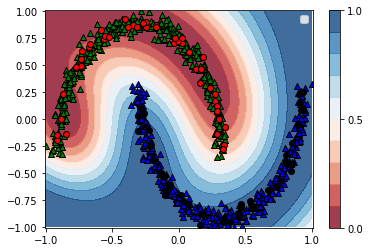

In [37]:
Z = np.reshape(predictions_grid, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])
plt.scatter(x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], c='g', marker='^', edgecolors='k',)
plt.scatter(x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], c='b', marker='^', edgecolors='k')
plt.scatter(x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], c='r', marker='o', edgecolors='k')
plt.scatter(x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], c='black', marker='o', edgecolors='k')

plt.ylim(-1.008, 1.008)
plt.xlim(-1.008, 1.008)

plt.show()

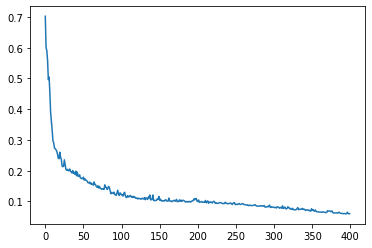

In [29]:
plt.plot(range(400),test_loss)

In [ ]:
lr

In [ ]:
lr*0.5

In [ ]:
(y_test==1).sum()

In [27]:
var

array([[[ 1.13449496,  0.28881491,  1.41365572],
        [ 1.04005053,  1.11646599, -1.71870497],
        [ 0.23246252, -0.40714122,  0.48893466],
        [ 1.21158487,  0.71205549, -0.76677812],
        [ 2.46779094, -0.92909167, -0.34517346],
        [-0.45782809,  0.81168315, -0.0658338 ]]])